# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

In this notebook we classify dog breeds. We will:
1. finetune a pretrained Inception v3 model
2. use Script Mode in Sagemaker
3. use Sagemaker Debugger to know what is happening when the model is training
4. use Sagemaker Profiler to khow how well we are using our instance resources like the CPU and GPU Memory
5. perform hyperparameter tuning in Sagemaker

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [28]:
import sagemaker
import boto3
import os
import io
import IPython
import numpy as np
import matplotlib.pyplot as plt

# Importing all the required modules from tuner
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# Importing all the required modules from debugger
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

from PIL import Image

from os import listdir
from os.path import isdir, join

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

## 1. Dataset
The dataset is located here: https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

The dataset consists of 8351 colour images of 133 classes (dog breeds). The dataset is divided to train, valid and test dataset with 6680, 835 and 836 images respectively.

Some classes (dog breeds) are:
1. Afghan hound
2. Briard
3. Otterhound
4. Pomeranian

### 1.1. Fetch the data

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-01-12 11:57:50--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  13.3MB/s    in 68s     

2022-01-12 11:58:59 (15.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

### 1.2. Upload the data to AWS S3

Preparing session, S3 bucket, prefix, region and role

In [4]:
# Getting sagemaker session
sagemaker_session = sagemaker.Session()

# Getting boto3 session
boto_session = boto3.session.Session()

# Getting default S3 bucket
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

# Prefix, where the images will be stored
prefix_data = 'dog-images'

print("Prefix: {}".format(prefix_data))

region = boto_session.region_name # "us-east-1"
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-831431249660
Prefix: dog-images
AWS Region: us-east-1
RoleArn: arn:aws:iam::831431249660:role/service-role/AmazonSageMaker-ExecutionRole-20220112T173849


Uploading data to the S3 bucket

In [6]:
# Directory, where the images are stored
data_dir = "dogImages"

inputs = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix_data)

In [7]:
print("The data is uploaded to {}".format(inputs))

The data is uploaded to s3://sagemaker-us-east-1-831431249660/dog-images


In [9]:
inputs = "s3://sagemaker-us-east-1-831431249660/dog-images"

Checking if the data correctly uploaded

In [9]:
s3 = boto3.resource('s3')
bucket_obj = s3.Bucket(bucket)
objects = bucket_obj.objects.all().filter(Prefix=prefix_data)

In [10]:
images_count = 8351
print("Uploaded sucessfully: {}".format(len(list(objects)) == images_count))

Uploaded sucessfully: True


## Hyperparameter Tuning
We use Inception v3 with one fully connected layer.

Hyperparameters we tune:
1. **lr [Learning rate]** - learning rate defines how fast the model trains. A large learning rate allows the model to learn faster, with a small learning rate it takes a longer time for the model to learn but with more accuracy. The **range** is from **0.001 to 0.1**.
2. **batch-size [Batch size]** - batch size is the number of examples from the training dataset used in the estimate of the error gradient. Batch size controls the accuracy of the estimate of the error gradient when training neural networks. The batch-size we choose between two numbers **64** and **128**.
3. **epochs** - epochs is the number of times that the learning algorithm will work through the entire training dataset. The epochs we choose between two numbers **2** and **5**.

For best accuracy we should add more hyperparameters and use bigger ranges, but our aim is not to get the best accuracy but to learn ML lifecycle.

In [11]:
# Hyperparameter ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([64, 128]),
    "epochs": CategoricalParameter([2, 5]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

Define estimator and hyperparameter tuner.

In [12]:
# Estimator
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

# HP tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [13]:
# Fitting HP Tuner
tuner.fit({"training": inputs}, wait=True)

...............................................................................................................................................................................................................................................................................................................................................................................................!


Getting the best estimator and the best HPs

In [14]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-12 12:34:16 Starting - Preparing the instances for training
2022-01-12 12:34:16 Downloading - Downloading input data
2022-01-12 12:34:16 Training - Training image download completed. Training in progress.
2022-01-12 12:34:16 Uploading - Uploading generated training model
2022-01-12 12:34:16 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '"5"',
 'lr': '0.0038297311117915494',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-12-12-18-08-931"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-12-12-18-08-931/source/sourcedir.tar.gz"'}

Define `best_hyperparameters` with the parameters we got from `best_estimator`

In [16]:
best_hyperparameters={
    'batch-size': best_estimator.hyperparameters()['batch-size'].replace('"', ""),
    'lr': best_estimator.hyperparameters()['lr'],
    'epochs': best_estimator.hyperparameters()['epochs'].replace('"', "")}

In [17]:
print("Best hyperparameters: {}".format(best_hyperparameters))

Best hyperparameters: {'batch-size': '128', 'lr': '0.0038297311117915494', 'epochs': '5'}


## Model Profiling and Debugging
Using the best hyperparameters, we create and finetune a new model

We use the `train_model.py` script to perform model profiling and debugging

In [5]:
# Defining best hyperparameters
best_hyperparameters={
    'batch-size': "128",
    'lr': "0.0038297311117915494",
    'epochs': "5"}

In [7]:
# Setting up debugging and profiling rules and configs
rules = [
    # The 'vanishing_gradient' rule detects if the gradients in a
    # trial become extremely small or drop to a zero magnitude.
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    
    # The 'overfit' rule detects if your model is being overfit to the
    # training data by comparing the validation and training losses.
    Rule.sagemaker(rule_configs.overfit()),
    
    # The 'overtraining' rule detects if a model is being overtrained.
    Rule.sagemaker(rule_configs.overtraining()),
    
    # The 'poor_weight_initialization' rule detects if your model 
    # parameters have been poorly initialized.
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    
    # The 'ProfilerReport' rule invokes all of the built-in rules for
    # monitoring and profiling.
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    
    # The 'LowGPUUtilization' rule helps detect if GPU utilization is low or 
    # suffers from fluctuations. This is checked for each GPU on each worker.
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    
    # The 'LoadBalancing' rule helps detect issues in workload
    # balancing among multiple GPUs.
    ProfilerRule.sagemaker(rule_configs.LoadBalancing()),
    
    # The 'BatchSize' rule helps detect if GPU is underutilized
    # due to a small batch size.
    ProfilerRule.sagemaker(rule_configs.BatchSize()),
    
    # The 'CPUBottleneck' rule helps detect if GPU is
    # underutilized due to CPU bottlenecks.
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
    
    # The 'GPUMemoryIncrease' rule helps detect a large
    # increase in memory usage on GPUs.
    ProfilerRule.sagemaker(rule_configs.GPUMemoryIncrease()),
    
    # The 'StepOutlier' rule helps detect outliers
    # in step durations.
    ProfilerRule.sagemaker(rule_configs.StepOutlier())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[
    CollectionConfig(name="CrossEntropyLoss_output_0",
    parameters={
        "include_regex": "CrossEntropyLoss_output_0", 
        "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(collection_configs=collection_configs)

In [10]:
# Creating an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", # using 1.6 as it has support for smdebug lib
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

# Fitting an estimator
estimator.fit({'training' : inputs}, wait=True)

2022-01-15 18:27:37 Starting - Starting the training job...
2022-01-15 18:27:39 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
LowGPUUtilization: InProgress
LoadBalancing: InProgress
BatchSize: InProgress
CPUBottleneck: InProgress
GPUMemoryIncrease: InProgress
StepOutlier: InProgress
......
2022-01-15 18:28:57 Starting - Preparing the instances for training.........
2022-01-15 18:30:38 Downloading - Downloading input data............
2022-01-15 18:32:39 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-15 18:32:37,972 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-15 18:32:37,992 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

In [11]:
# getting latest_training_job.name
training_job_name = estimator.latest_training_job.name

In [12]:
# Printing training jobname
region = boto_session.region_name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-01-15-18-27-36-726
Region: us-east-1


In [13]:
# Creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-01-15 18:44:11.900 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:35 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/debug-output


In [14]:
# All the tensor names that were tracked
print("All the tensor names:")
trial.tensor_names()

All the tensor names:
[2022-01-15 18:44:17.083 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:35 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-15 18:44:18.107 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:35 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/Inception3_fc.0.bias',
 'gradient/Inception3_fc.0.weight']

In [15]:
# Number of datapoints for train mode
print("Number of datapoints for TRAIN mode:")
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))

Number of datapoints for TRAIN mode:
27


In [16]:
# Number of datapoints for eval mode
print("Number of datapoints for EVAL mode:")
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Number of datapoints for EVAL mode:
35


### Plot the debugging output

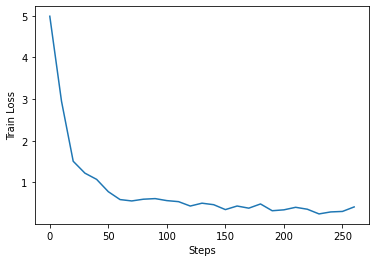

In [17]:
import matplotlib.pyplot as plt
from smdebug.trials import create_trial

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.TRAIN).values()))
plt.show()

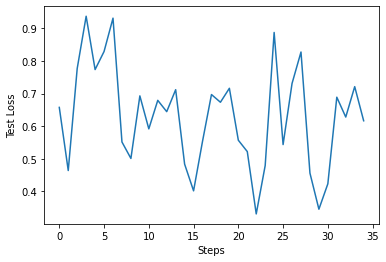

In [18]:
import matplotlib.pyplot as plt
from smdebug.trials import create_trial

plt.ylabel('Test Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.EVAL),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.EVAL).values()))
plt.show()

As we see there are some anomalous behaviour in the debugging output:
1. In the TRAIN mode as steps are increased the loss is decreased. The graph is smooth.
2. In the EVAL mode as steps are increased we cannot say the loss is decreased. The graph isn't smooth.

Here are some ways that may help to fix that:
1. Adding more hyperparameters to tune.
2. Increasing hyperparameter ranges for hpo tuning.
3. Increasing `max_jobs` for hpo tuning.
4. Adding more Fully Connected layers to the pretrained model.

### Display the profiler output

Visualize timeline graph

In [19]:
training_job = TrainingJob(training_job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = training_job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-831431249660/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/profiler-output


Profiler data from system is available
[2022-01-15 18:48:04.589 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:35 INFO metrics_reader_base.py:134] Getting 14 event files
select event

We generate Debugger Profiling Report

In [20]:
# Defining path for profiler report
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/rule-output


In [21]:
# Viewing files in rule_output_path
! aws s3 ls {rule_output_path} --recursive

2022-01-15 18:43:32     406783 pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-15 18:43:31     260500 pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-15 18:43:26        192 pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-15 18:43:26      31366 pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-15 18:43:26        126 pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-15 18:43:26        327 pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-15 18:43:26       2490 pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-re

In [22]:
# Downloading report from rule_output_path
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-831431249660/pytorch-traini

In [23]:
# getting the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [24]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

Firstly, we get list of the dog breeds from `dogImages/` directory, save the list in `dog_breeds` and sort the list

In [25]:
# Getting list of dog breeds from `dogImages/` directory
dog_breeds_path = "./dogImages/test"
dog_breeds = [f[4:] for f in listdir(dog_breeds_path) if isdir(join(dog_breeds_path, f))]

In [26]:
# Sorting dog breeds alphanumerically
dog_breeds.sort()

In [27]:
# Showing the list of dog breeds
dog_breeds

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

### Deploying the  model to an endpoint
We deploy the model to an endpoint with `ml.t2.medium` instance type

In [29]:
# s3 location of the model
model_dir = "s3://sagemaker-us-east-1-831431249660/pytorch-training-2022-01-15-18-27-36-726/output/model.tar.gz"

# Defining the serializer and deserializer
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

# Defining custom Predictor 
class ImgPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(model_data=model_dir,
    role = role,
    entry_point= "inference.py",
    py_version = "py36",
    framework_version = "1.6",
    predictor_cls = ImgPredictor)

In [30]:
# Defining the predictor
predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.t2.medium")

------------!

In [31]:
# Printing and endpoint
endpoint = predictor.endpoint_name
print("Endpoint: {}".format(endpoint))

Endpoint: pytorch-inference-2022-01-15-18-52-49-590


## Run predictions
We are going to run 4 predictions on test images

### Test #1

In [39]:
# Defining the image path
image_path_01 = "dogImages/test/016.Beagle/Beagle_01156.jpg"

In [41]:
with open(image_path_01, "rb") as f:
    payload_01 = f.read()

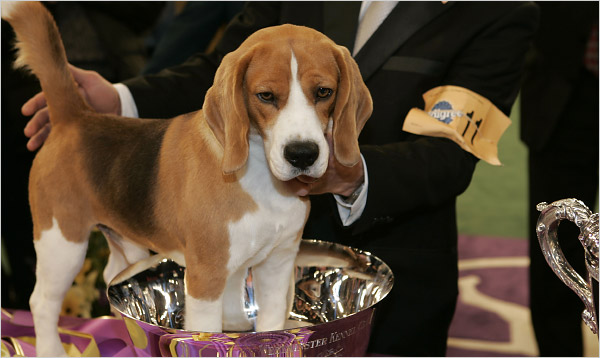

In [42]:
display(Image.open(io.BytesIO(payload_01)))

Here we predict prepared image on the endpoint

In [43]:
# Predicting
response_01 = predictor.predict(payload_01, initial_args={"ContentType": "image/jpeg"})

In [44]:
# Getting index of the predicted dog breed
predicted_dog_breed_idx_01 = np.argmax(response_01, 1)[0]

In [45]:
# Printing the predicted dog breed
print("Predicted dog breed: {}".format(dog_breeds[predicted_dog_breed_idx_01]))

Predicted dog breed: Beagle


### Test #2

In [46]:
# Defining the image path
image_path_02 = "dogImages/test/034.Boxer/Boxer_02413.jpg"

In [47]:
with open(image_path_02, "rb") as f:
    payload_02 = f.read()

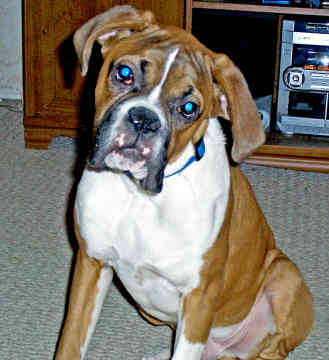

In [48]:
display(Image.open(io.BytesIO(payload_02)))

In [49]:
# Predicting
response_02 = predictor.predict(payload_02, initial_args={"ContentType": "image/jpeg"})

In [50]:
# Getting index of the predicted dog breed
predicted_dog_breed_idx_02 = np.argmax(response_02, 1)[0]

In [51]:
# Printing the predicted dog breed
print("Predicted dog breed: {}".format(dog_breeds[predicted_dog_breed_idx_02]))

Predicted dog breed: Boxer


### Test #3

In [54]:
# Defining the image path
image_path_03 = "dogImages/test/100.Lowchen/Lowchen_06694.jpg"

In [55]:
with open(image_path_03, "rb") as f:
    payload_03 = f.read()

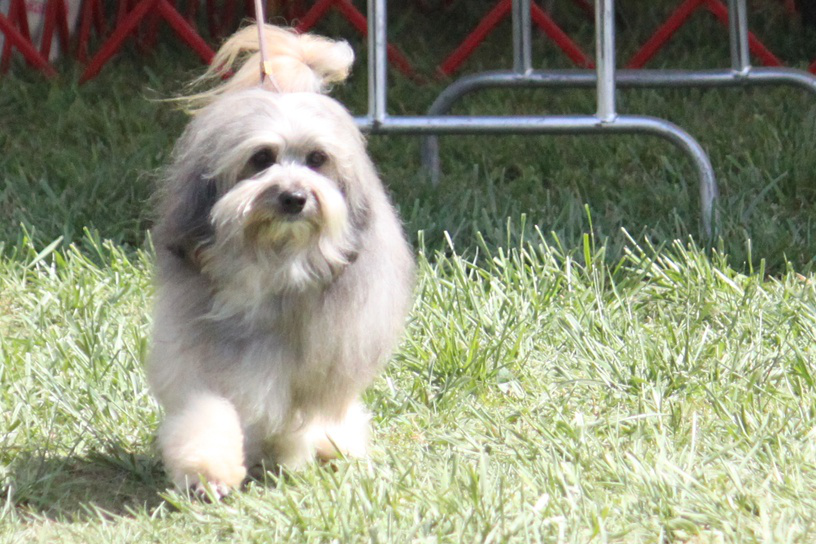

In [56]:
display(Image.open(io.BytesIO(payload_03)))

In [57]:
# Predicting
response_03 = predictor.predict(payload_03, initial_args={"ContentType": "image/jpeg"})

In [58]:
# Getting index of the predicted dog breed
predicted_dog_breed_idx_03 = np.argmax(response_03, 1)[0]

In [59]:
# Printing the predicted dog breed
print("Predicted dog breed: {}".format(dog_breeds[predicted_dog_breed_idx_03]))

Predicted dog breed: Lhasa_apso


### Test #4

In [60]:
# Defining the image path
image_path_04 = "dogImages/test/124.Poodle/Poodle_07949.jpg"

In [61]:
with open(image_path_04, "rb") as f:
    payload_04 = f.read()

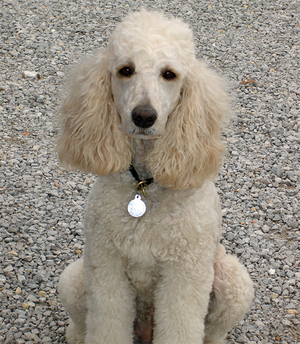

In [62]:
display(Image.open(io.BytesIO(payload_04)))

In [63]:
# Predicting
response_04 = predictor.predict(payload_04, initial_args={"ContentType": "image/jpeg"})

In [64]:
predicted_dog_breed_idx_04 = np.argmax(response_04, 1)[0]

In [65]:
# Printing the predicted dog breed
print("Predicted dog breed: {}".format(dog_breeds[predicted_dog_breed_idx_04]))

Predicted dog breed: Poodle


In [66]:
# Deleting the endpoint
predictor.delete_endpoint()